Model has 83k params
Initial training loss: 4.708757400512695, val loss: 4.115387439727783
iter:0 training loss: 4.760354042053223, val loss: 4.115387439727783
iter:5 training loss: 4.161866664886475, val loss: 3.523552417755127
iter:10 training loss: 3.6988754272460938, val loss: 2.969521999359131
iter:15 training loss: 3.215344190597534, val loss: 2.487348794937134
iter:20 training loss: 2.8074252605438232, val loss: 2.0997769832611084
iter:25 training loss: 2.360668659210205, val loss: 1.7513782978057861
iter:30 training loss: 2.0656802654266357, val loss: 1.4338511228561401
iter:35 training loss: 1.6940429210662842, val loss: 1.189267873764038
iter:40 training loss: 1.47920823097229, val loss: 1.010015606880188
iter:45 training loss: 1.3380767107009888, val loss: 0.8310478925704956
iter:50 training loss: 1.1400028467178345, val loss: 0.6999397277832031
iter:55 training loss: 0.9365813136100769, val loss: 0.5940150618553162
iter:60 training loss: 0.9481300115585327, val loss: 0.5316

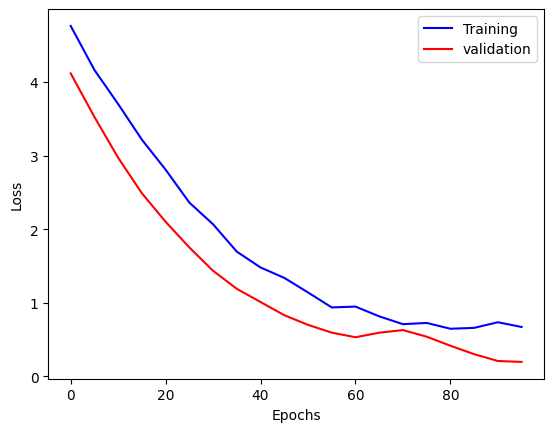

In [4]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import time
import random
import math
PATH = "models/baby_gpt_100k_1.91.bin"

inf = torch.inf
context_length = 2 # No of tokens
model_dim = 64 # dimension of the model -> residual stream
n_layers = 2 # no of layers
head_dim = 16
vocab_size = 65
learning_rate = 1e-4
max_iters = 100
eval_iters = 10
batch_size = 32 #Takes 27k iters

lower_triangular_matrix = torch.tensor([[1 if i<=j else -torch.inf for i in range(context_length)] for j in range(context_length)]).float()

def tokenise(str: str):
    return torch.tensor([char_map[i] for i in str])

def decode(tokens: list[str]):
    return ''.join([reverse_char_map[i] for i in tokens])

file = open("tiny_shakesphere.txt", "r")
full_data = "110100100101001"

vocab = list(sorted((set(full_data))))

char_map = {vocab[i]: i for i in range(len(vocab))}
reverse_char_map = {char_map[i] : i for i in char_map}
full_data = tokenise(full_data)

total_datapoints  = full_data.shape[0]

training_data : list[int] = full_data[:int(total_datapoints*0.9)]
validation_data = full_data[int(total_datapoints*0.9):total_datapoints]


def sample_data(split: str = "train"): # With replacement
    data = training_data if split == 'train' else validation_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = sample_data(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    
    return out["train"], out['val']


class Layer(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        

class AttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.key = nn.Linear(model_dim, head_dim)
        self.query = nn.Linear(model_dim, head_dim)
        self.value = nn.Linear(model_dim, head_dim)
        self.proj = nn.Linear(head_dim, model_dim)
    
    def forward(self, idx):
        key = self.key(idx) # (batch, context_length, head_dim)
        query = self.query(idx)
        value = self.value(idx) # (batch, context_length, head_dim)

        attention = (query@torch.transpose(key,1,2))/(math.sqrt(head_dim)) # (batch, context_length, context_length)

        attention = torch.tril(attention)

        attention = attention.masked_fill(attention == 0, -inf)

        attention = F.softmax(attention,-1) # probs along context_length sum to 1

        attention_value = attention@value  # (batch, context_length, head_dim)

        return self.proj(attention_value)  # (batch, context_length, model_dim)
    

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(model_dim, 4*model_dim), nn.Linear(4*model_dim, model_dim))
        self.relu = nn.ReLU()
    
    def forward(self, idx):
        logits = self.layers(idx)
        return self.relu(logits)

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, model_dim)
        self.pos_embedding = nn.Embedding(context_length, model_dim)
        self.attention_layes = nn.ModuleList([AttentionHead() for i in range(n_layers)])
        self.mlp_layers = nn.ModuleList([MLP() for i in range(n_layers)])
        self.unembed_layer = nn.Linear(model_dim,vocab_size)

        self.total_parameters = sum([p.numel() for p in self.parameters()])
        print(f"Model has {self.total_parameters//1000}k params")


    def forward(self, idx, targets = None):
        # idx -> [1,2,0,3..] (batch, context_length)

        # for p in range(idx.shape[0]):
        #     print([decode(idx[p].tolist()), decode(targets[p].tolist())])

        input_sequence_length = idx.shape[-1]

        residual_stream = self.token_embedding(idx)  # (batch, context_length, model_dim)
        residual_stream = residual_stream + self.pos_embedding(torch.tensor([i for i in range(input_sequence_length)])) # Pos embedding will be # (context_length, model_dim)
        
        for i in range(n_layers):
            residual_stream = residual_stream + self.attention_layes[i](residual_stream)
            residual_stream = residual_stream + self.mlp_layers[i](residual_stream)

        residual_stream = self.unembed_layer(residual_stream) # (batch, context_length, vocab_size)
        if targets is None:
            return residual_stream
        (x,y,z) = residual_stream.shape
        loss = F.cross_entropy(residual_stream.view(x*y,z), targets.view(x*y))
        return residual_stream, loss
    
model = Transformer()

LOAD_MODEL = False
if LOAD_MODEL:
    model = Transformer()
    model.load_state_dict(torch.load(PATH))
    model.eval()

train_loss,val_loss = estimate_loss()
print(f"Initial training loss: {train_loss}, val loss: {val_loss}")

loss_value = []
val_loss_value = []
iters = []
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
step_value = max_iters/20
start_time = time.time()
for iter in range(max_iters):
    X,Y= sample_data() # (B, context_length)
    logits, loss = model(X, Y)  # (B, context_length, vocab_size)
    if iter%step_value ==0:
        train_loss,val_loss = estimate_loss()
        iters.append(iter)
        loss_value.append(train_loss)
        val_loss_value.append(val_loss)
        print(f"iter:{iter} training loss: {train_loss}, val loss: {val_loss}")

    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()



        